In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from pyfishsensedev.fish import FishHeadTailDetector, FishSegmentationFishialPyTorch, FishSegmentationFishialOnnx
from pyfishsensedev.image import ImageRectifier, RawProcessor
from pyfishsensedev.laser import LaserDetector
from pyfishsensedev import WorldPointHandler

import pyfishsense
FishSegmentation = pyfishsense.fish.FishSegmentation

In [2]:
# plt.rcParams['figure.figsize'] = [25, 12.5]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
lens_calibration_path = Path("./data/lens-calibration.pkg")
laser_calibration_path = Path("./data/laser-calibration.pkg")

# input_file = "./data/P7170081.ORF"
# input_file = "./data/P8030201.ORF"
# input_file = "./data/P8030161.ORF"
# input_file = "./data/P8030158.ORF"
# input_file = "./data/P8030088.ORF"
input_file = "./data/P8030135.ORF"

In [4]:
def imshow(img: np.ndarray):
    """
    Helper function for showing images in this notebook.
    """
    img = uint16_2_uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)

def uint16_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 65535

def uint16_2_uint8(img: np.ndarray) -> np.ndarray:
    return (uint16_2_double(img) * 255).astype(np.uint8)

In order to have greater control over the image processing steps, begin with the RAW output.  This allows us to keep more information than would be possible otherwise.

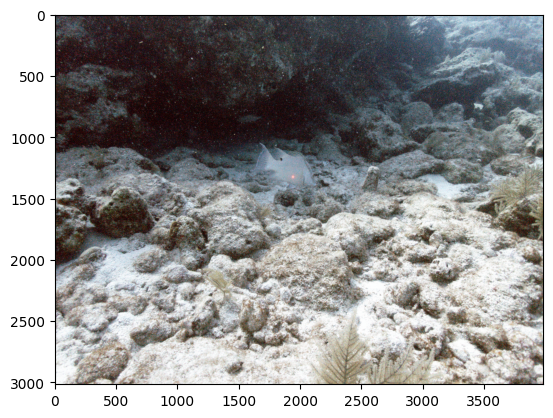

In [5]:
raw_processor_hist_eq = RawProcessor()
raw_processor = RawProcessor(enable_histogram_equalization=False)

image_rectifier = ImageRectifier(lens_calibration_path)

img = raw_processor_hist_eq.load_and_process(Path(input_file))
img_dark = raw_processor.load_and_process(Path(input_file))

img = image_rectifier.rectify(img)
img_dark = image_rectifier.rectify(img_dark)

img8 = uint16_2_uint8(img)
img_dark8 = uint16_2_uint8(img_dark)

imshow(img)

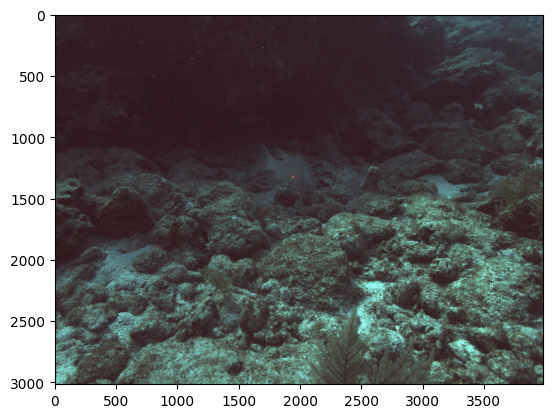

In [6]:
imshow(img_dark)

We can consider the brightest points in the image as regions of interest (ROI).  For each, we can use an ML model to check to see if they are the laser.

In [7]:
laser_detector = LaserDetector(lens_calibration_path, laser_calibration_path, device)
laser_coords = laser_detector.find_laser(img_dark8)

imshow(img)
plt.plot(laser_coords[0], laser_coords[1], 'r.')
plt.show()

/home/chris/.cache/pypoetry/virtualenvs/fishsense-lite-FT9UdjYx-py3.11/lib/python3.11/site-packages/pyfishsensedev/laser/laser_detector.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

FileNotFoundError: [Errno 2] No such file or directory: '/home/chris/.cache/pypoetry/virtualenvs/fishsense-lite-FT9UdjYx-py3.11/lib/python3.11/site-packages/pyfishsensedev/laser/models/laser_detection.pth'

We use Fishial to find the mask for the fish.

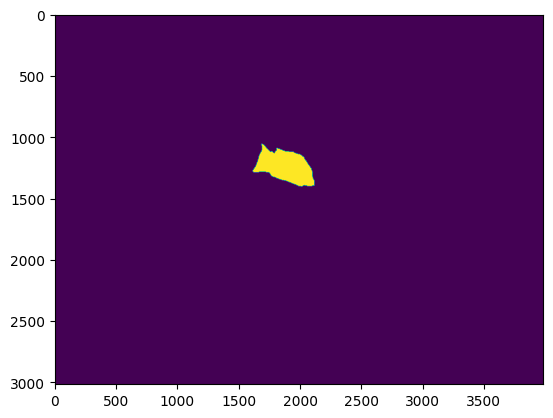

In [ ]:
# fish_segmentation_inference = FishSegmentationFishialPyTorch(device)
# fish_segmentation_inference = FishSegmentationFishialOnnx()
fish_segmentation_inference = FishSegmentation()
segmentations = fish_segmentation_inference.inference(img8)

plt.imshow(segmentations)
plt.show()

Given the location of the laser previously calculated, we can choose the fish that has the laser on it.

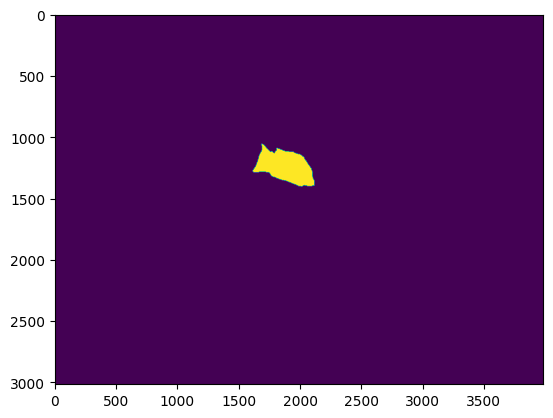

In [ ]:
mask = np.zeros_like(segmentations, dtype=bool)
mask[segmentations == segmentations[laser_coords[1], laser_coords[0]]] = True

plt.imshow(mask)
plt.show()

We can then use the axis of most symmetry for the blob to detect the head and tail.

head left


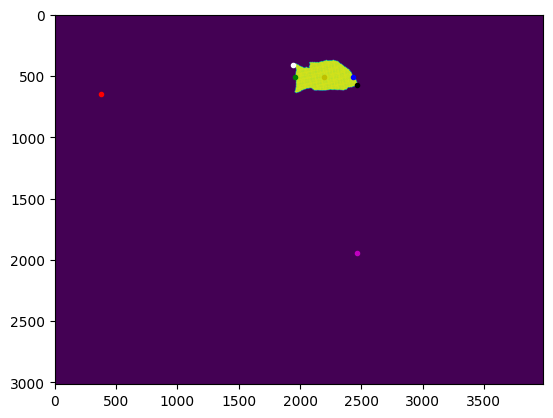

In [ ]:
fish_head_tail_detector = FishHeadTailDetector()

# From: https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

from math import atan, cos, sin
left_coord, right_coord = fish_head_tail_detector._pca_find_left_right(mask)

m = (left_coord[1] - right_coord[1]) / (left_coord[0] - right_coord[0])
theta = atan(m)
rotation = np.array([
    [cos(theta), -sin(theta)],
    [sin(theta), cos(theta)]
])
rotation_inv = np.linalg.inv(rotation)

left_coord = rotation_inv @ left_coord
right_coord = rotation_inv @ right_coord

x, y = np.nonzero(mask)
mask_coords = np.array([y, x]).T
mask_coords = np.array([rotation_inv @ mask_coords[i, :] for i in range(mask_coords.shape[0])]).astype(int)

rotated_mask = np.zeros_like(mask)
rotated_mask[mask_coords[:, 1], mask_coords[:, 0]] = True

moments = cv2.moments(rotated_mask.astype(np.uint8))

# calculate x,y coordinate of center
cX = int(moments["m10"] / moments["m00"])
cY = int(moments["m01"] / moments["m00"])

centroid = np.array([cX, cY])

rmin, rmax, cmin, cmax = bbox(rotated_mask)

p1_arg = np.argmin(np.abs(mask_coords[:, 0] - rmin))
p1 = mask_coords[p1_arg, :]
z1 = np.abs(p1[0] - centroid[0])

p2_arg = np.argmin(np.abs(mask_coords[:, 0] - cmax))
p2 = mask_coords[p2_arg, :]
z2 = np.abs(p2[0] - centroid[0])

if z1 < z2:
    print("head left")
else:
    print("head right")

# # Draw a line
# line_direction = (right_coord - left_coord) / np.linalg.norm(
#     right_coord - left_coord
# )

# is_neg = line_direction[0] / line_direction[1]
# perp_direction = np.array([-line_direction[1], line_direction[0]])

# mid_point = (left_coord) + (right_coord - left_coord) / 2

# height, width = mask.shape
# m = perp_direction[1] / perp_direction[0]
# b = mid_point[1] - m * mid_point[0]

# x_coord = np.tile(np.arange(width), (height, 1))
# y_coord = np.tile(np.arange(height), (width, 1)).T

# right_mask = np.logical_and((m * x_coord + b) < y_coord, mask)
# left_mask = np.logical_and((m * x_coord + b) > y_coord, mask)

# if is_neg:
#     right_mask, left_mask = left_mask, right_mask

# moments = cv2.moments(mask.astype(np.uint8))

# # calculate x,y coordinate of center
# cX = int(moments["m10"] / moments["m00"])
# cY = int(moments["m01"] / moments["m00"])

# centroid = np.array([cX, cY])

# left_left_coord, _ = fish_head_tail_detector._pca_find_left_right(left_mask)
# _, right_right_coord = fish_head_tail_detector._pca_find_left_right(right_mask)

# # Fish have more body mass on their head side than their tail side.
# # Let's use this.
# if np.linalg.norm(left_coord - centroid) >= np.linalg.norm(
#     right_coord - centroid
# ):
#     print("left")
#     tail_coord = left_left_coord

#     b = right_coord[1] - m * right_coord[0]
#     head_mask = np.logical_and((m * x_coord + b) > y_coord, right_mask)

# else:
#     print("right")
#     tail_coord = right_right_coord

#     b = left_coord[1] - m * left_coord[0]
#     head_mask = np.logical_and((m * x_coord + b) < y_coord, left_mask)

# mask_coords = np.array(np.nonzero(head_mask)).T
# line_coords = np.vstack((mask_coords[:, 0], m * mask_coords[:, 0] + b)).T

# argmax = np.argmax([np.min(np.linalg.norm(mask_coords[i, :] - line_coords, axis=1)) for i in range(mask_coords.shape[0])])
# head_coord = np.array([mask_coords[argmax, 1], mask_coords[argmax, 0]])


# imshow(img)
plt.imshow(rotated_mask)
plt.plot(left_coord[0], left_coord[1], 'g.')
plt.plot(right_coord[0], right_coord[1], 'b.')
plt.plot(centroid[0], centroid[1], 'y.')
plt.plot(p1[0], p1[1], 'w.')
plt.plot(p2[0], p2[1], 'k.')
plt.plot(rmin, rmax, 'r.')
plt.plot(cmax, cmin, 'm.')
plt.show()

We can use the laser location to find the distance to the fish.

In [ ]:
world_point_handler = WorldPointHandler(lens_calibration_path, laser_calibration_path)
laser_coords3d = world_point_handler.calculate_laser_parallax(laser_coords)

print(f"Distance to the fish is {laser_coords3d[2]: 0.2f}m.")

Distance to the fish is  1.16m.


We can finally use this distance and project the head/tail locations to this distance.  Using this, we can calculate the final length.

In [ ]:
left_coord3d, right_coord3d = world_point_handler.calculate_world_coordinates_with_depth(left_coord, right_coord, laser_coords3d[2])

length = np.linalg.norm(left_coord3d - right_coord3d)
print(f"Fish Length is {length: 0.2f}m.")

Fish Length is  0.19m.
